In [7]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.backends.backend_pdf import PdfPages
from math import *
import pickle

from pathlib import Path
from tqdm.auto import tqdm

# coding: utf-8
import time
# import cProfile
# from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# from FuncionesAuxFinal import *

In [8]:
import sys
sys.path.append('..')

In [9]:
from lib.models import HMM, HMMFilter
from lib.policies import StaticRoutingPolicy, MinimalDelayRoutingPolicy
from lib.policies import StaticMonitoringPolicy, RecedingHorizonPolicy
from lib.simulator import Scenario, Simulator, DiscreteFilter, Logbook

In [10]:
# scenarios_dir = Path('../dataset/NLNOG/scenarios_v2/2_paths/')
# scenarios_paths = [x for x in scenarios_dir.iterdir() if x.is_dir()]

In [13]:
olivier_scenarios = [
#     '2_paths/Paris_Tokyo',
#     '2_paths/Singapore_Moscow',
#     '3_paths/Singapore_HongKong',
    '5_paths/Warsaw_Singapore',
#     '4_paths/Paris_Santiago'
]


scenarios_dir = Path('../dataset/NLNOG/scenarios_v2/')
scenarios_paths = [scenarios_dir.joinpath(x) for x in olivier_scenarios]

In [14]:
benchmarks = {}

# Progress bar
p = tqdm(scenarios_paths)

series_temp={}
for scenario_path in p:
    if scenario_path!='.ipynb_checkpoints':
        scenario = Scenario.from_path(scenario_path)
        # en scenario.timeseries tengo las series temporales para cada ruta
        series_temp[scenario.name]=scenario.timeseries
        print(scenario.timeseries[0])
        benchmark = {'logs': {}}

        # Constant monitoring cost
        costs = np.ones(scenario.n_paths) * 0.5

        # (Routing Policy, Monitoring Policy)
        policies = []

        # IP Path
        policies.append((
            StaticRoutingPolicy(0),
            StaticMonitoringPolicy(np.zeros(scenario.n_paths))
        ))

        # Receding Horizon
        policies.append((
            MinimalDelayRoutingPolicy(),
            RecedingHorizonPolicy(scenario.models, costs, τ_max=100, ρ=0.9, H=1, one_route=False)
        ))
        
        for routing_policy, monitoring_policy in policies:
            policy_name = '{} / {}'.format(routing_policy, monitoring_policy)
            p.set_description('{} ({})'.format(scenario.name, policy_name))

            try:
                sim = Simulator(scenario.timeseries, scenario.models, costs)
                print(sim.timeseries)
                benchmark['logs'][policy_name] = sim.benchmark(monitoring_policy, routing_policy)
            except Exception as e:
                print('Failed to simulate {}'.format(policy_name))
                print(e)

        benchmarks[scenario.name] = benchmark


[345.741 343.786 344.946 ... 286.633 286.48  277.613]
[array([345.741, 343.786, 344.946, ..., 286.633, 286.48 , 277.613]), array([343.936, 343.737, 343.309, ..., 345.202, 345.135, 345.349]), array([355.911, 361.072, 385.408, ..., 341.675, 342.416, 346.873]), array([348.541, 349.454, 348.402, ..., 379.042, 378.743, 379.454]), array([323.175, 323.219, 323.085, ..., 323.22 , 323.174, 327.647])]


[array([345.741, 343.786, 344.946, ..., 286.633, 286.48 , 277.613]), array([343.936, 343.737, 343.309, ..., 345.202, 345.135, 345.349]), array([355.911, 361.072, 385.408, ..., 341.675, 342.416, 346.873]), array([348.541, 349.454, 348.402, ..., 379.042, 378.743, 379.454]), array([323.175, 323.219, 323.085, ..., 323.22 , 323.174, 327.647])]


In [49]:
# tomo datos para el RH <-- si uso mas de una politica en benchmarks tengo que encarar aca
# for scenario, benchmark in benchmarks.items():
#     for policy, log in benchmark['logs'].items():
#         print(policy)
#         print(log)
#         if policy=='Static Route 0 / Never Measure':
#             pass
#         else:
#             rutas=log.get('state')[:]
# print (rutas)

###################################

for scenario_path in p:
    if scenario_path!='.ipynb_checkpoints':
        scenario = Scenario.from_path(scenario_path)

print(scenario)
T = len(scenario.timeseries[0])

# Filters
# TODO: Start in stationnary dist. (τ_init = τ_max) ?

routing_policy=MinimalDelayRoutingPolicy()
monitoring_policy=RecedingHorizonPolicy(scenario.models, np.array([0, 0, 0, 0, 0]), τ_max=100, ρ=0.9, H=1, one_route=False)

# print(benchmark['logs']['{} / {}'.format(routing_policy, monitoring_policy)])

hmm_filters = [HMMFilter(model) for model in scenario.models]
mdp_filters = [DiscreteFilter(model, τ_init=0) for model in scenario.models]

rutas=[[],[], [], [], []]
# rutas=[]

for t in tqdm(range(T), leave=False):
#     print(mdp_filters[0].z, mdp_filters[0].τ, mdp_filters[1].z, mdp_filters[1].τ)
#     start_time = time.process_time_ns()
#     action = monitoring_policy.action(mdp_filters)
    action = [1, 1, 1, 1, 1]
#     processing_time = time.process_time_ns() - start_time
#     print(action)
    for i, a in enumerate(action):
        if a:
            hmm_filters[i].update(scenario.timeseries[i][t])
            mdp_filters[i].update(np.argmax(hmm_filters[i].belief))
        else:
#             hmm_filters[i].predict()
#             mdp_filters[i].predict()
            hmm_filters[i].update(scenario.timeseries[i][t])
            mdp_filters[i].update(np.argmax(hmm_filters[i].belief))
    rutas[0].append(mdp_filters[0].z)
    rutas[1].append(mdp_filters[1].z)
    rutas[2].append(mdp_filters[2].z)
    rutas[3].append(mdp_filters[3].z)
    rutas[4].append(mdp_filters[4].z)

# print(rutas)


Warsaw_Singapore scenario with 5 paths
- K = [5, 6, 8, 7, 4]
- Avg. delays = [310.84, 347.47, 355.48, 379.04, 351.75]


In [50]:
def Value_Func(estados, RTT, ro, cost_measure, max_slots):
    # RTT es el vector de valores que va tomando el camino elegido en cada time_slot
    # ro factor de descuento
    # cost_measure vector de costo de medida en cada time_slot
    # max_slots es que tanto considero el futuro
    # en V guardo el promedio de la value function del estado que supero N visitas, y cuantas veces pase por ese estado
    V={}
    val=np.zeros(len(RTT)-max_slots)
    vector_ro=(np.ones(max_slots)*ro)**np.arange(max_slots)
    RTT=np.array(RTT)
    cost_measure=np.array(cost_measure)
    # print(max_slots)
    # print(vector_ro)
    # print(RTT)
    # print(cost_measure)
    for i in range(len(RTT)-max_slots):
        # print(i)
        val[i]=sum((RTT[i:i+max_slots]+cost_measure[i:i+max_slots])*vector_ro.T)
        # print(val[i])
        if estados[i] in V:
            V[estados[i]]=[(val[i]+V[estados[i]][0]*V[estados[i]][1])/(V[estados[i]][1]+1), V[estados[i]][1]+1]
            # print(V[estados[i]])
        # print(RTT[i:i+max_slots]+cost_measure[i:i+max_slots])
        else:
            V[estados[i]]=[val[i], 1]
    return V


In [51]:
vector_t=[1, 2, 3, 4, 5, 6, 7, 8]#, 9, 10]#, 12, 14, 16, 18, 20]#, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
# vector_t=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]#, 22, 25, 27, 30]#, 40, 50, 60, 70, 80, 90, 100]

# tengo las series temporales en scenario.timeseries[ruta]
# for scenario, benchmark in benchmarks.items():
#     series_temp[scenario.name]=scenario.timeseries
ro=0.9
################################
# armo vector de entrenamiento #
################################
ent=0.63
val=0.07
largo_ent=int(ent*len(scenario.timeseries[0]))
largo_val=int(val*len(scenario.timeseries[0]))
largo_test=len(scenario.timeseries[0])-largo_ent-largo_val
# largo de la muestra total 
# largo_ent=4000
# largo_val=1000
# largo_ent2=4000
# largo_test=3000
largo_total=largo_ent+largo_val+largo_test

print(largo_ent, largo_val, largo_test, len(scenario.timeseries[0]))
# print(scenario.timeseries[0])
# print (scenario.timeseries)

rutas_mod=np.zeros((len(scenario.timeseries), len(scenario.timeseries[0])))
for i in range(len(scenario.timeseries)):
    rutas_mod[:][i]=scenario.timeseries[i]

print(rutas_mod)

2416 268 1151 3835
[[345.741 343.786 344.946 ... 286.633 286.48  277.613]
 [343.936 343.737 343.309 ... 345.202 345.135 345.349]
 [355.911 361.072 385.408 ... 341.675 342.416 346.873]
 [348.541 349.454 348.402 ... 379.042 378.743 379.454]
 [323.175 323.219 323.085 ... 323.22  323.174 327.647]]


In [52]:

###########################
# Random Forest, T select #
###########################

# armo vector de ent. y de val.

factor=int((largo_ent+largo_val)/largo_val)
print('factor es de ', factor)
dic_rf={}

# creo diccionario para ir guardando los valores
for T in vector_t:
    dic_rf[T]=[[],0]

for f in range(factor):

    ini_muestras_val=f*largo_val
    muestras_val=rutas_mod[:, ini_muestras_val:ini_muestras_val+largo_val]
    muestras_ent=np.concatenate((rutas_mod[:,:ini_muestras_val],rutas_mod[:,ini_muestras_val+largo_val:largo_ent+largo_val]),axis=1)

    ################################
    # armo vector de entrenamiento #
    ################################
    for T in vector_t:
        # serie es la ruta ideal (ruta 0, ruta 1, ruta 2) y serie_mod es el valor del RTT
        serie=[]
        serie_mod=[]
        # serie_ent[i] es la ruta i para entrenamiento
        serie_ent=[[],[], [], [], []]
        for i in range(largo_ent-T+1):
            for k in range(T):
                serie.append(np.argmin(muestras_ent[:,i+k]))
                serie_mod.append(min(muestras_ent[:,i+k]))
        #         serie_1.append(rutas_mod[0][i])
        #         serie_2.append(rutas_mod[1][i])
#                 serie_ent[0].append(muestras_ent[0][i+trunc(k/T)*T])
#                 serie_ent[1].append(muestras_ent[1][i+trunc(k/T)*T])
                for j in range(len(rutas_mod)):
                    serie_ent[j].append(muestras_ent[j][i])
        tiempo=list(range(T))*int(largo_ent-T+1)
#         print(len(serie))
        ######################################
        # armo el problema a resolver con RF #
        ######################################
        measures = {'tiempo': tiempo, 'ruta 1': serie_ent[0], 'ruta 2': serie_ent[1], 'ruta 3': serie_ent[2], 'ruta 4': serie_ent[3], 'ruta 5': serie_ent[4], 'ruteo': serie}
        df = pd.DataFrame(measures,columns= ['tiempo', 'ruta 1', 'ruta 2', 'ruta 3', 'ruta 4', 'ruta 5', 'ruteo'])
#         measures = {'tiempo ruta 1': tiempo[0],'tiempo ruta 2': tiempo[1], 'ruta 1': serie_ent[0], 'ruta 2': serie_ent[1], 'ruteo': serie}
#         measures = {'tiempo': tiempo, 'ruta 1': serie_ent[0], 'ruta 2': serie_ent[1], 'ruteo': serie}
#         df = pd.DataFrame(measures,columns= ['tiempo', 'ruta 1', 'ruta 2', 'ruteo'])
#         df = pd.DataFrame(measures,columns= ['tiempo', 'ruta 1', 'ruta 2', 'ruteo'])
        # print (df)
        X = df[['tiempo', 'ruta 1', 'ruta 2', 'ruta 3', 'ruta 4', 'ruta 5']]
#         X = df[['tiempo', 'ruta 1', 'ruta 2']]
#         X = df[['tiempo ruta 1', 'tiempo ruta 2', 'ruta 1', 'ruta 2']]
        y = df['ruteo']
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0)
        clf = RandomForestClassifier(n_estimators=10)
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
#         print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
        # confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
        # sn.heatmap(confusion_matrix, annot=True)
        # print (X_test) #test dataset (without the actual outcome)
        # print (y_pred) #predicted values
        # tengo que ver como armar el vector de entrada para realizar las predicciones
        prediction=[]
        estado_rf=[]
        # print(len(rutas_mod[1]))
        k=30
        for i in range(largo_val):
            [ruta]=clf.predict([[i%T, muestras_val[0][(i-i%T)], muestras_val[1][(i-i%T)], muestras_val[2][(i-i%T)], muestras_val[3][(i-i%T)], muestras_val[4][(i-i%T)]]])
            estado_rf.append((rutas[0][ini_muestras_val+(i-i%T)], i%T, rutas[1][ini_muestras_val+(i-i%T)], i%T, rutas[2][ini_muestras_val+(i-i%T)], i%T, rutas[3][ini_muestras_val+(i-i%T)], i%T, rutas[4][ini_muestras_val+(i-i%T)], i%T))
#             [ruta]=clf.predict([[i%T, muestras_val[0][(i-i%T)], muestras_val[1][(i-i%T)]]])
#             estado_rf.append((rutas[0][ini_muestras_val+(i-i%T)], i%T, rutas[1][ini_muestras_val+(i-i%T)], i%T))
            # si elijo la ruta 1
            prediction.append(muestras_val[ruta][i])
        costo_medida_T=(largo_val/T)*sum(costs)
        # print(costo_medida_T)
        costo_RF=[0]*T
        costo_RF[0]=sum(costs)
        costo_RF=costo_RF*(trunc(largo_val/T)+1)
        costo_RF=costo_RF[0:largo_val]
#         print(sum(costo_RF))
        val_rf_test=Value_Func(estado_rf, prediction, ro, costo_RF, k)# min(max_slots))
        v_medio_rf=0
        v_muestras_rf=0
        for key in val_rf_test.keys():
            v_medio_rf=(v_medio_rf*v_muestras_rf+val_rf_test[key][0]*val_rf_test[key][1])/(v_muestras_rf+val_rf_test[key][1])
            v_muestras_rf+=val_rf_test[key][1]
        dic_rf[T]=[clf, (v_medio_rf+dic_rf[T][1]*f)/(f+1)]

print(dic_rf)
T_min=min(dic_rf.items(), key=lambda x: x[1][1])[0]
T=T_min
clf=min(dic_rf.items(), key=lambda x: x[1][1])[1]
# print(clf)
fval_T=dic_rf[T][1]
print(T, fval_T)

factor es de  10
{1: [RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 2954.8688101691305], 2: [RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n

In [53]:
# print(dic_rf_Ti[(19, 20)][1])

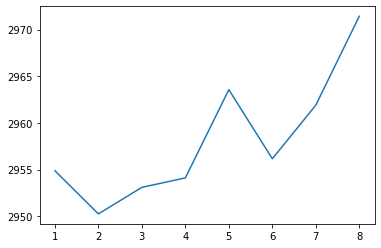

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 2950.242219302391]


In [54]:
base=[]
base1=[]
base2=[]
valor=[]
for T in vector_t:
    base.append(T)
    valor.append(dic_rf[(T)][1])
plt.plot(base, valor)
plt.show()
print(clf)

In [55]:
logbook = Logbook(costs)

# tengo que ver como armar el vector de entrada para realizar las predicciones
prediction=[]
estado_rf=[]
# print(len(rutas_mod[1]))
for i in range(largo_test):
    costo_accion=0
    start_time = time.process_time_ns()
    [ruta]=clf[0].predict([[i%T, rutas_mod[0][largo_ent+(i-i%T)], rutas_mod[1][largo_ent+(i-i%T)], rutas_mod[2][largo_ent+(i-i%T)], rutas_mod[3][largo_ent+(i-i%T)], rutas_mod[4][largo_ent+(i-i%T)]]])
#         [ruta]=clf[0].predict([[i%T, rutas_mod[0][largo_ent+largo_val+(i-i%T)], rutas_mod[1][largo_ent+largo_val+(i-i%T)]]])
    processing_time = time.process_time_ns() - start_time
    estado_rf.append((rutas[0][largo_ent+largo_val+(i-i%T)], i%T, rutas[1][largo_ent+largo_val+(i-i%T)], i%T, rutas[2][largo_ent+largo_val+(i-i%T)], i%T, rutas[3][largo_ent+largo_val+(i-i%T)], i%T, rutas[4][largo_ent+largo_val+(i-i%T)], i%T))
#         estado_rf.append((rutas[0][largo_ent+largo_val+(i-i%T)], i%T, rutas[1][largo_ent+largo_val+(i-i%T)], i%T))
    # si elijo la ruta 1
    if i%T==0:
        costo_accion+=sum(costs)
    prediction.append(rutas_mod[ruta][largo_ent+largo_val+i])
    logbook.record({
    #         'hmm_filters': hmm_filters,
    #         'mdp_filters': mdp_filters,
        # guardo T en action pa saber...
        'action': costo_accion,
        'delay': rutas_mod[ruta][largo_ent+largo_val+i],
        'route_pred': ruta,
        'estado_rf': estado_rf,
        'processing_time': processing_time,
    })
costo_medida_T=(largo_test/T)*sum(costs)
# print(costo_medida_T)
numero_medidas=len(costs)*largo_test/T
costo_RF=[0]*T
costo_RF[0]=sum(costs)
costo_RF=costo_RF*(int(largo_test/T)+1)
benchmark['logs']['Random Forest']=logbook
print(benchmark['logs'])
# print(benchmark['logs']['Random Forest'])

{'Static Route 0 / Never Measure': <lib.simulator.Logbook object at 0x7fc9b8607950>, 'Minimal Delay / RH(ρ=0.9,H=1)': <lib.simulator.Logbook object at 0x7fc9b85595d0>, 'Random Forest': <lib.simulator.Logbook object at 0x7fc9b504ee90>}


In [56]:
def get_benchmark_df(benchmarks):
    records = []

    for scenario, benchmark in benchmarks.items():
        for policy, log in benchmark['logs'].items():
            if policy=='Random Forest':
                records.append({
                    'scenario': scenario,
                    'policy': policy,
                    'avg_delay': np.mean(log.get('delay')),
                    'avg_cost': log.avg_cost(),
                    'avg_processing_time': log.avg_processing_time() / 1e3,
                    'avg_n_measures': log.avg_n_measures()
                })
            else:
                records.append({
                    'scenario': scenario,
                    'policy': policy,
                    'avg_delay': np.mean(log.get('delay')[largo_ent+largo_val:]),
                    'avg_cost': log.avg_cost(),
                    'avg_processing_time': log.avg_processing_time() / 1e3,
                    'avg_n_measures': log.avg_n_measures()
                })
            
    return pd.DataFrame.from_records(records)

In [57]:
get_benchmark_df(benchmarks)

,avg_cost,avg_delay,avg_n_measures,avg_processing_time,policy,scenario
0,0.000000,300.926066,0.000000,4.250839,Static Route 0 / Never Measure,Warsaw_Singapore
1,0.396219,300.488911,0.792438,28370.223715,"Minimal Delay / RH(ρ=0.9,H=1)",Warsaw_Singapore
2,0.156386,309.680845,0.312772,1844.195300,Random Forest,Warsaw_Singapore


In [44]:
# tomo datos para el RH <-- si uso mas de una politica en benchmarks tengo que encarar aca
for scenario, benchmark in benchmarks.items():
    for policy, log in benchmark['logs'].items():
        print(policy)
        print(log)
        if policy=='Static Route 0 / Never Measure' or policy=='Random Forest':
            pass
        else:
            delay_RH=log.get('delay')[largo_ent+largo_val:]
            avg_medidas_RH=log.avg_n_measures()

Static Route 0 / Never Measure
Minimal Delay / RH(ρ=0.9,H=1)
Random Forest


In [45]:
# print(scenario.models)
# print(sim.timeseries)

minimo=[]
for i in range(largo_test):
    minimo.append(np.min(rutas_mod[:,i+largo_ent+largo_val]))
print(sum(minimo))
print(largo_ent,largo_val,largo_test, len(minimo))

for scenario, benchmark in benchmarks.items():
    print(scenario)
#     print(benchmark['logs'].items())
    for policy, log in benchmark['logs'].items():
        gap=0
        no_min=0
#         print(policy, len(delay))
#         minimo=delay
#         print(minimo)
        if policy=='Random Forest':
            delay=log.get('delay')
            minimo=[]
            for i in range(len(delay)):
                minimo.append(np.min(rutas_mod[:,i+largo_ent+largo_val]))
                gap+=(delay[i]-minimo[i])/minimo[i]
            print(sum(minimo))
        else:
            minimo=[]
            delay=log.get('delay')[largo_ent+largo_val:]
            print(len(delay), len(series_temp[scenario]))
            for i in range(len(delay)):
                minimo.append(np.min(rutas_mod[:,i+largo_ent+largo_val]))
                gap+=(delay[i]-minimo[i])/minimo[i]
            print(sum(minimo))
        print(policy, gap*1./len(delay))
# print(sum(minimo))

441962.03900000046
1917 383 1535 1535
Warsaw_Singapore
1535 5
441962.03900000046
Static Route 0 / Never Measure 0.028867626042548406
1535 5
441962.03900000046
Minimal Delay / RH(ρ=0.9,H=1) 0.025666886079251616
441962.03900000046
Random Forest 0.05635854742303472


In [46]:
print (avg_medidas_RH)
print(len(delay_RH), len(delay), len(prediction), len(minimo))

0.7924380704041721
1535 1535 1535 1535


In [47]:
print('costo de ruta 1', sum(rutas_mod[0][largo_ent+largo_val:]))
print('costo de ruta 2', sum(rutas_mod[1][largo_ent+largo_val:]))
print('costo de ruta 3', sum(rutas_mod[2][largo_ent+largo_val:]))
print('costo de ruta 4', sum(rutas_mod[3][largo_ent+largo_val:]))
print('costo de ruta 5', sum(rutas_mod[4][largo_ent+largo_val:]))
print('costo de ruta ideal ', sum(minimo))
print('################## Random Forest #########################')
print('mediciones ', numero_medidas)
print('costo de mediciones ', costo_medida_T)
print('costo de ruta elegida ', sum(prediction))
print('costo total RF', costo_medida_T+sum(prediction))
print('################## Receding Horizon #########################')
print('mediciones ', largo_test*avg_medidas_RH)
print('costo de mediciones ', costs[0]*largo_test*avg_medidas_RH)
print('costo de ruta elegida ', sum(delay_RH))
print('costo total RH', sum(delay_RH)+costs[0]*largo_test*avg_medidas_RH)

# x=np.arange(largo_test)
# plt.plot(x, rutas_mod[0][largo_ent:], '-g', x, rutas_mod[1][largo_ent:], '-r', x, rutas_mod[2][largo_ent:], '-b', x, prediction, '*m', x, delay_RH, '+k')
# plt.show()
# plt.plot(x, rutas_mod[0][largo_ent:], '-g', x, rutas_mod[1][largo_ent:], '-r', x, prediction, '*m', x, delay_RH, '+k')
# plt.show()
# plt.savefig('Delay'+str(scenario)+'RF.pdf')

costo de ruta 1 456571.77199999994
costo de ruta 2 541355.7509999992
costo de ruta 3 557583.3060000011
costo de ruta 4 610289.232
costo de ruta 5 524865.3420000001
costo de ruta ideal  441962.03900000046
################## Random Forest #########################
mediciones  959.375
costo de mediciones  479.6875
costo de ruta elegida  468169.9319999999
costo total RF 468649.6194999999
################## Receding Horizon #########################
mediciones  1216.3924380704043
costo de mediciones  608.1962190352021
costo de ruta elegida  454962.5600000001
costo total RH 455570.7562190353


Warsaw_Singapore
{'logs': {'Static Route 0 / Never Measure': <lib.simulator.Logbook object at 0x7fc9b8607950>, 'Minimal Delay / RH(ρ=0.9,H=1)': <lib.simulator.Logbook object at 0x7fc9b85595d0>, 'Random Forest': <lib.simulator.Logbook object at 0x7fc9b53d1310>}}
[343.936 343.737 343.309 ... 345.202 345.135 345.349]
[355.911 361.072 385.408 ... 341.675 342.416 346.873]
[348.541 349.454 348.402 ... 379.042 378.743 379.454]
[323.175 323.219 323.085 ... 323.22  323.174 327.647]


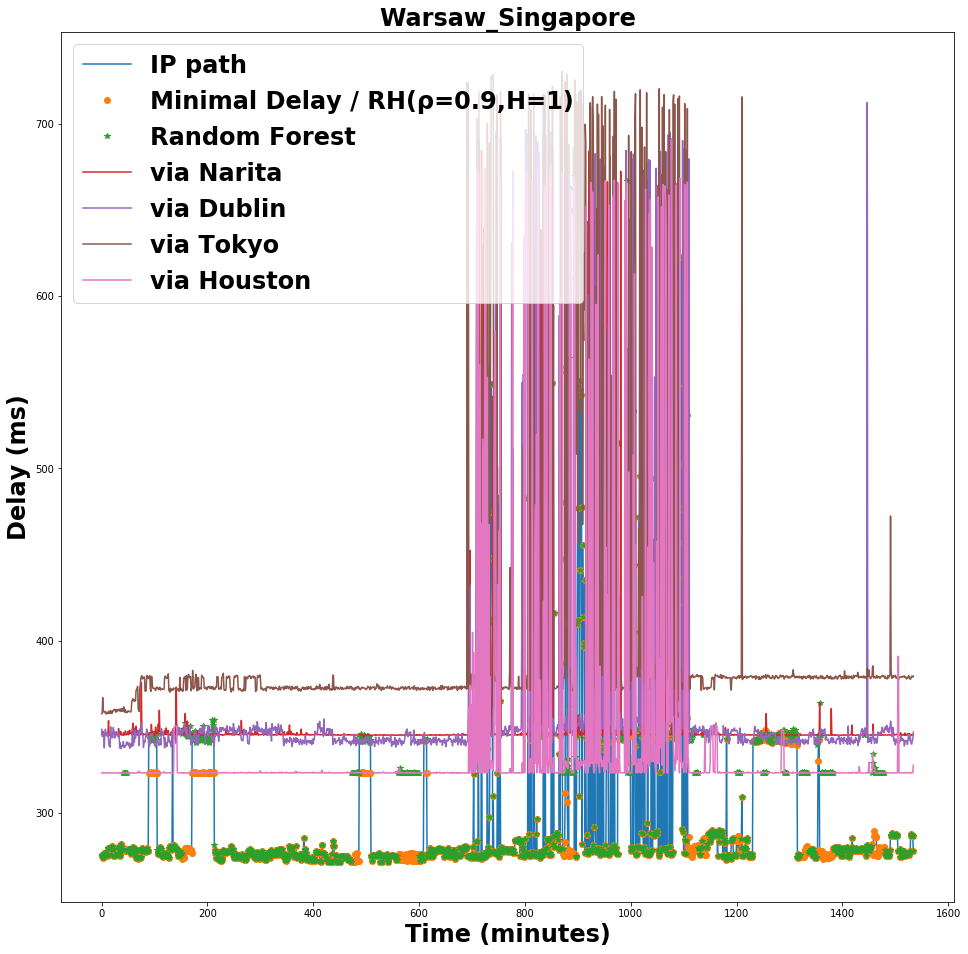

In [48]:
# ploteo el RH y el RF para el test

legend_properties = {'weight':'bold', 'size':'24'}
proxies={'Paris_Tokyo': ['IP path', 'via Calgary'], 'Singapore_Moscow': ['IP path', 'Alternate path'], 'Singapore_HongKong': ['IP path', 'via Tokyo', 'via Narita'], 'Haifa_Santiago': ['IP path', 'via Curitiva', 'via Dublin', 'via Boston'], 'Paris_Santiago': ['IP path', 'via Cocoa', 'via Boston', 'via Dublin'], 'Warsaw_Singapore': ['IP path', 'via Narita', 'via Dublin', 'via Tokyo', 'via Houston']}
for scenario, benchmark in benchmarks.items():
    print(scenario)
    print(benchmark)
    fig=plt.figure(figsize=(16,16))
    ax=fig.add_subplot(1,1,1)
    for policy, log in benchmark['logs'].items():
#         print(policy)
#         print(log)
        if policy=='Static Route 0 / Never Measure':
            ax.plot(log.get('delay')[largo_ent+largo_val:], label='IP path')
        elif policy=='Random Forest':
            ax.plot(log.get('delay'), '*', label=policy)
        else:
            ax.plot(log.get('delay')[largo_ent+largo_val:], 'o', label=policy)
    for paths in range(1, len(proxies[scenario])):
        print(series_temp[scenario][paths])
        ax.plot(series_temp[scenario][paths][largo_ent+largo_val:], label=proxies[scenario][paths])
    
#     ax.plot(prediction, '*', label='Random Forest')
    ax.set_xlabel('Time (minutes)', fontsize=24, weight='bold')
    ax.set_ylabel('Delay (ms)', fontsize=24, weight='bold')
    ax.set_title(str(scenario), fontsize=24, weight='bold')
    plt.legend(prop=legend_properties)
    plt.savefig('DelayTuneando'+str(scenario)+'.pdf')
    #     plt.show()



In [87]:
# # measures = {'tiempo': tiempo, 'ruta 1': serie_ent[0], 'ruta 2': serie_ent[1], 'ruta 3': serie_ent[2], 'ruta 4': serie_ent[3], 'ruteo': serie}#
# measures = {'tiempo': tiempo, 'ruta 1': serie_ent[0], 'ruta 2': serie_ent[1], 'ruteo': serie}#

# # df = pd.DataFrame(measures,columns= ['tiempo', 'ruta 1', 'ruta 2', 'ruta 3', 'ruta 4', 'ruteo'])
# df = pd.DataFrame(measures,columns= ['tiempo', 'ruta 1', 'ruta 2', 'ruteo'])
# # print (df)

In [21]:
# # tengo las series temporales en scenario.timeseries[ruta]
# # for scenario, benchmark in benchmarks.items():
# #     series_temp[scenario.name]=scenario.timeseries

# ################################
# # armo vector de entrenamiento #
# ################################
# ent=0.65
# largo_ent=int(ent*len(scenario.timeseries[0]))
# largo_test=len(scenario.timeseries[0])-largo_ent

# T=10

# # print(largo_test)
# # print(scenario.timeseries[0])
# # print (scenario.timeseries)

# rutas_mod=np.zeros((len(scenario.timeseries), len(scenario.timeseries[0])))
# for i in range(len(scenario.timeseries)):
#     rutas_mod[:][i]=scenario.timeseries[i]

# print(rutas_mod)

# # serie es la ruta ideal (ruta 0, ruta 1, ruta 2) y serie_mod es el valor del RTT
# serie=[]
# serie_mod=[]
# # serie_ent[i] es la ruta i para entrenamiento
# #############################
# # Cambiar esta linea si cambia el numero de rutas
# # serie_ent=[[],[],[],[]]
# serie_ent=[[],[]]
# for i in range(largo_ent-T+1):
#     for k in range(T):
#         serie.append(np.argmin(rutas_mod[:,i+k]))
#         serie_mod.append(min(rutas_mod[:,i+k]))
# #         serie_1.append(rutas_mod[0][i])
# #         serie_2.append(rutas_mod[1][i])
#         for j in range(len(scenario.timeseries)):
#             serie_ent[j].append(rutas_mod[j][i])

# print(len(serie_ent[0]), len(serie_ent[1]), len(serie))
# # print(serie_1)
# # print(serie)
# # print(serie_mod)
# # print(rutas_mod[0])
# # print(rutas_mod[1])

# tiempo=list(range(T))*int(largo_ent-T+1)
# print(len(tiempo))



In [22]:
# # X = df[['tiempo', 'ruta 1', 'ruta 2', 'ruta 3', 'ruta 4']]
# X = df[['tiempo', 'ruta 1', 'ruta 2']]
# y = df['ruteo']

In [23]:
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=0)

In [24]:
# clf = RandomForestClassifier(n_estimators=10)
# clf.fit(X_train,y_train)
# y_pred=clf.predict(X_test)

In [25]:
# print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))

In [26]:
# # tengo que ver como armar el vector de entrada para realizar las predicciones
# prediction=[]
# # print(len(rutas_mod[1]))
# for i in range(largo_test):
#     [ruta]=clf.predict([[i%T, rutas_mod[0][largo_ent+(i-i%T)], rutas_mod[1][largo_ent+(i-i%T)]]])
# #     [ruta]=clf.predict([[i%T, rutas_mod[0][largo_ent+(i-i%T)], rutas_mod[1][largo_ent+(i-i%T)], rutas_mod[2][largo_ent+(i-i%T)], rutas_mod[3][largo_ent+(i-i%T)]]])
#     # si elijo la ruta 1
# #     print(ruta)
#     prediction.append(rutas_mod[ruta][largo_ent+i])

# costo_medida_T=(largo_test/T)*costs[0]

In [71]:
# print('costo de ruta 1', sum(rutas_mod[0][largo_ent:]))
# print('costo de ruta 2', sum(rutas_mod[1][largo_ent:]))
# # print('costo de ruta 3', sum(rutas_mod[2][largo_ent:]))
# # print('costo de ruta 4', sum(rutas_mod[3][largo_ent:]))
# # print('costo de ruta ideal ', sum(ruta_ideal))
# print('################## Random Forest #########################')
# print('mediciones ', largo_test/T)
# print('costo de mediciones ', costo_medida_T)
# print('costo de ruta elegida ', sum(prediction))
# print('costo total RF', costo_medida_T+sum(prediction))
# print('################## Receding Horizon #########################')
# print('mediciones ', largo_test*avg_medidas_RH)
# print('costo de mediciones ', costs[0]*largo_test*avg_medidas_RH)
# print('costo de ruta elegida ', sum(delay_RH))
# print('costo total RH', sum(delay_RH)+costs[0]*largo_ent*avg_medidas_RH)

# # x=np.arange(largo_test)
# # plt.plot(x, rutas_mod[0][largo_ent:], '-g', x, rutas_mod[1][largo_ent:], '-r', x, rutas_mod[2][largo_ent:], '-b', x, prediction, '*m', x, delay_RH, '+k')
# # plt.show()
# # plt.plot(x, rutas_mod[0][largo_ent:], '-g', x, rutas_mod[1][largo_ent:], '-r', x, prediction, '*m', x, delay_RH, '+k')
# # plt.show()
# # plt.savefig('Delay'+str(scenario)+'RF.pdf')

In [ ]:
infile = open('DatosH3_NOoneroute.pickle','rb')
benchmarks = pickle.load(infile)
infile.close()
print(benchmarks)

Paris_Tokyo
{'logs': {'Static Route 0 / Never Measure': <lib.simulator.Logbook object at 0x7fa68821e310>, 'Minimal Delay / RH(ρ=0.9,H=1)': <lib.simulator.Logbook object at 0x7fa68b3a9e10>, 'Random Forest': <lib.simulator.Logbook object at 0x7fa68824f410>}}
[249.121 249.061 249.072 ... 247.613 247.601 247.675]
[247.214 246.946 247.162 ... 248.791 250.347 248.803]


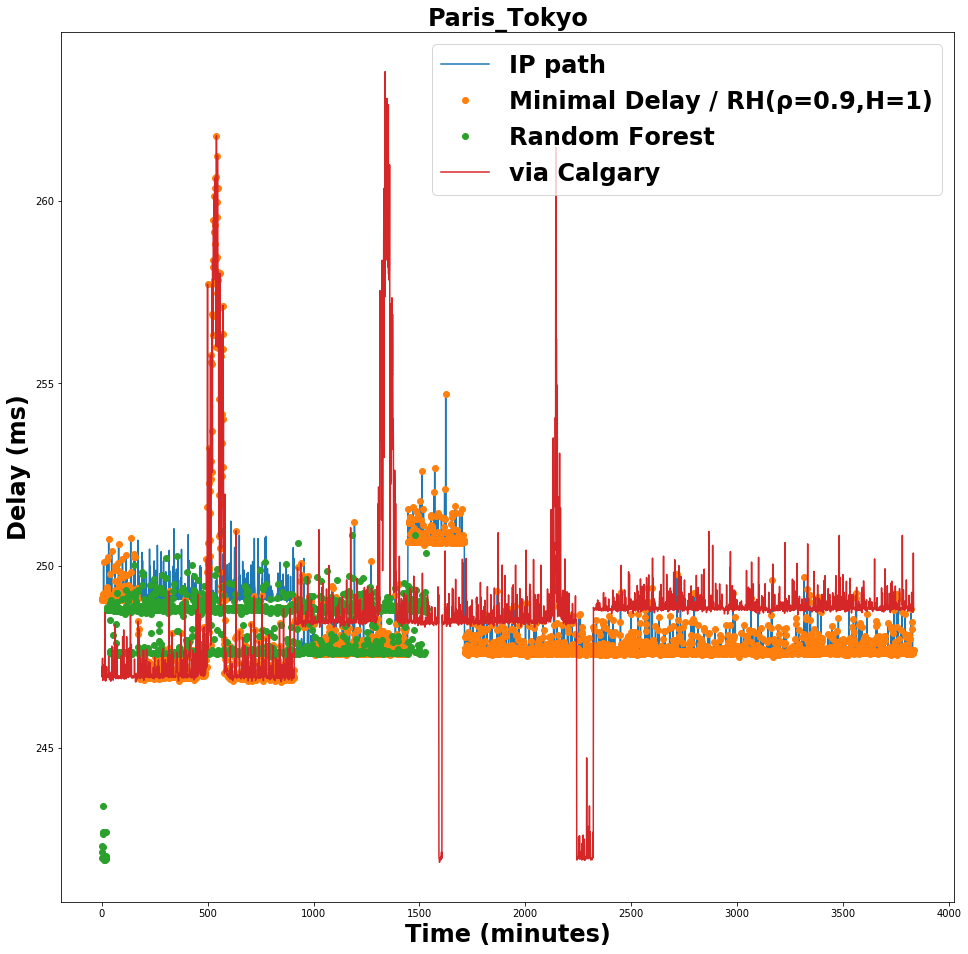

In [88]:
# print(scenario.models)
# print(sim.timeseries)
legend_properties = {'weight':'bold', 'size':'24'}
proxies={'Paris_Tokyo': ['IP path', 'via Calgary'], 'Singapore_HongKong': ['IP path', 'via Tokyo', 'via Narita'], 'Haifa_Santiago': ['IP path', 'via Curitiva', 'via Dublin', 'via Boston'], 'Paris_Santiago': ['IP path', 'via Cocoa', 'via Boston', 'via Dublin']}
for scenario, benchmark in benchmarks.items():
    print(scenario)
    print(benchmark)
    fig=plt.figure(figsize=(16,16))
    ax=fig.add_subplot(1,1,1)
    for policy, log in benchmark['logs'].items():
#         print(policy)
#         print(log)
        if policy=='Static Route 0 / Never Measure':
            ax.plot(log.get('delay'), label='IP path')
        else:
            ax.plot(log.get('delay'), 'o', label=policy)
    print(series_temp[scenario][0])
    for paths in range(1, len(proxies[scenario])):
        print(series_temp[scenario][paths])
        ax.plot(series_temp[scenario][paths], label=proxies[scenario][paths])
    ax.set_xlabel('Time (minutes)', fontsize=24, weight='bold')
    ax.set_ylabel('Delay (ms)', fontsize=24, weight='bold')
    ax.set_title(str(scenario), fontsize=24, weight='bold')
    plt.legend(prop=legend_properties)
    plt.savefig('Delay'+str(scenario)+'.pdf')
#     plt.show()

In [73]:
get_benchmark_df(benchmarks)

,avg_cost,avg_delay,avg_n_measures,avg_processing_time,policy,scenario
0,0.000000,248.308882,0.000000,2.368142,Static Route 0 / Never Measure,Paris_Tokyo
1,0.001173,248.084757,0.002347,1193.049230,"Minimal Delay / RH(ρ=0.9,H=1)",Paris_Tokyo


In [ ]:
import pickle
filename = 'Paris_Tokyo'
outfile = open(filename,'wb')
pickle.dump(benchmarks,outfile)
outfile.close()

In [12]:
infile = open(filename,'rb')
new_dict = pickle.load(infile)
infile.close()
print(new_dict)

{'Haifa_Santiago': {'logs': {'Static Route 0 / Never Measure': <lib.simulator.Logbook object at 0x7fc53c1a3590>, 'Minimal Delay / RH(ρ=0.99,H=3)': <lib.simulator.Logbook object at 0x7fc535f1aa10>}}}


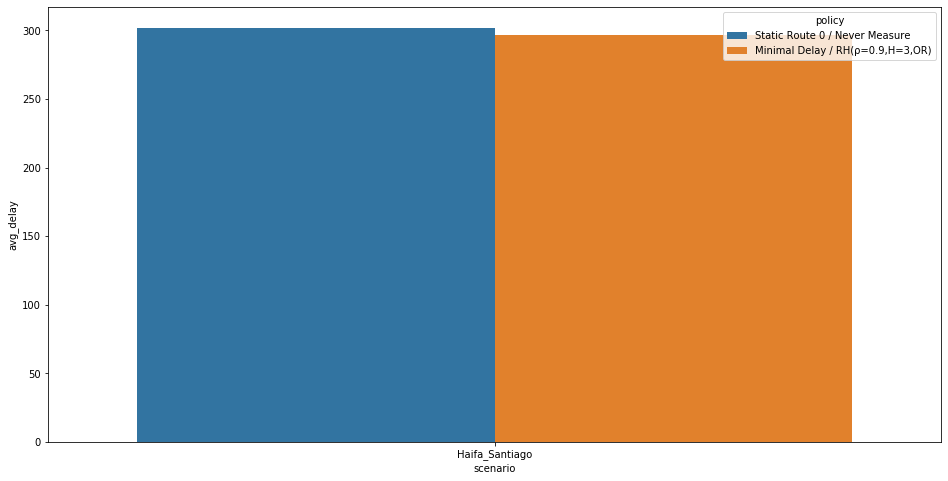

In [60]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_delay', hue='policy', data=df)
# plt.savefig('../figures/benchmark_delay_v2.png', bbox_inches='tight', dpi=300)

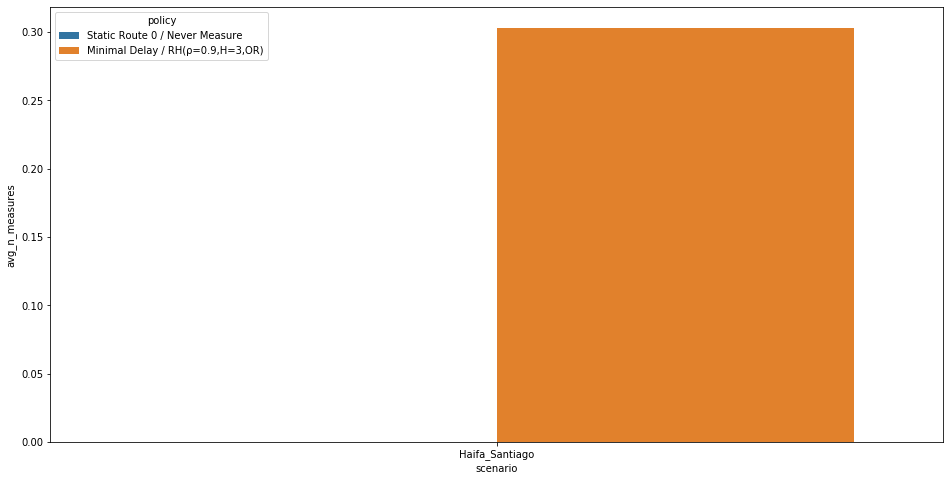

In [61]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_n_measures', hue='policy', data=df)
# plt.savefig('../figures/benchmark_cost_v2.png', bbox_inches='tight', dpi=300)

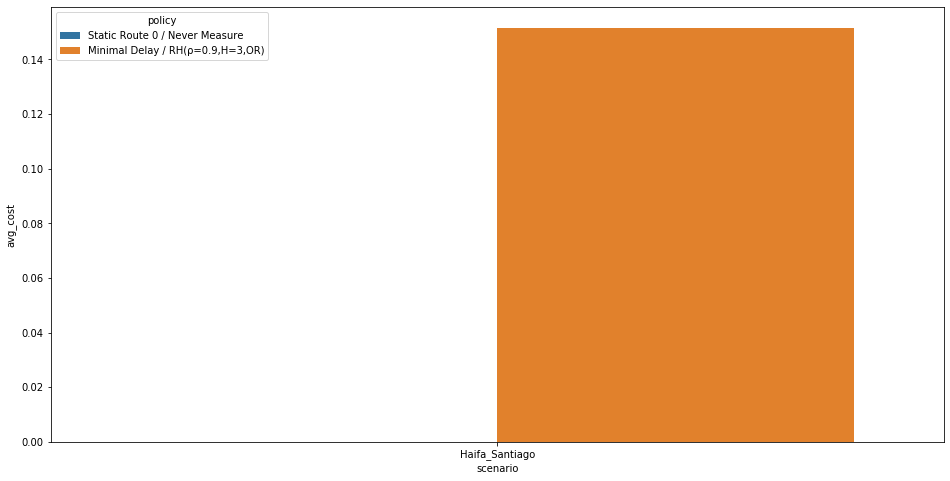

In [62]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_cost', hue='policy', data=df)
# plt.savefig('../figures/benchmark_cost_v2.png', bbox_inches='tight', dpi=300)

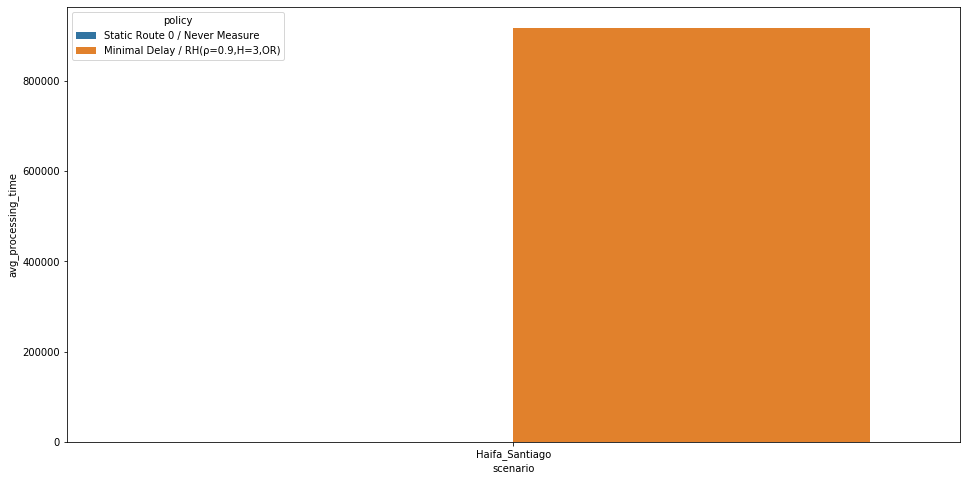

In [63]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_processing_time', hue='policy', data=df)
# plt.savefig('../figures/benchmark_acc_v2.png', bbox_inches='tight', dpi=300)